<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- 여러 알고리즘으로 만든 모델의 성능을 교차 검증을 통해 예측해 봅니다.
- 성능이 좋을 것으로 예상되는 알고리즘으로 최적화된 성능의 모델을 만듭니다.
- 튜닝된 모델의 성능을 평가합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
# 데이터 불러오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data['CHURN'] = data['CHURN'].map({'STAY':0, 'LEAVE': 1})

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- **CHURN: 이탈(번호이동) 여부**

In [3]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


In [4]:
# 기술통계 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,0.492600
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,0.499958
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,0.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,0.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,0.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,1.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000,1.000000


In [5]:
# 변수 관련 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           20000 non-null  int64 
 1   COLLEGE                      20000 non-null  int64 
 2   INCOME                       20000 non-null  int64 
 3   OVERAGE                      20000 non-null  int64 
 4   LEFTOVER                     20000 non-null  int64 
 5   HOUSE                        20000 non-null  int64 
 6   HANDSET_PRICE                20000 non-null  int64 
 7   OVER_15MINS_CALLS_PER_MONTH  20000 non-null  int64 
 8   AVERAGE_CALL_DURATION        20000 non-null  int64 
 9   REPORTED_SATISFACTION        20000 non-null  object
 10  REPORTED_USAGE_LEVEL         20000 non-null  object
 11  CONSIDERING_CHANGE_OF_PLAN   20000 non-null  object
 12  CHURN                        20000 non-null  int64 
dtypes: int64(10), object(3)
memory 

# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [6]:
# 변수 제거
drop_cols = ['id']
data.drop(columns=drop_cols, inplace=True)

# 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**2) x, y 분리**

In [7]:
# x, y 분리
target = 'CHURN'
x = data.drop(columns=target)
y = data[target]

**3) 가변수화**

In [8]:
# 가변수화
dumm_cols =['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns=dumm_cols, drop_first=True, dtype=int)

# 확인
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,0,0,1,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0


**4) 학습용, 평가용 데이터 분리**

In [9]:
# 학습용, 평가용 데이터 분리
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

**5) 정규화**

In [10]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

# 4.성능 예측

- 여러 알고리즘으로 만든 모델의 성능을 교차 검증을 통해 예측해 봅니다.
- 하이퍼파라미터를 설정하지 않고 진행합니다.
- 예측된 성능 정보를 수집해 마지막에 비교합니다.

In [11]:
# xgboost 설치
# !pip install xgboost

In [12]:
# lightgbm 설치
# !pip install lightgbm

- 이후 사용할 함수를 모두 불러옵니다.

In [13]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

**1) KNN**

- KNN 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [14]:
# 성능예측
cv_score = cross_val_score(KNeighborsClassifier(), x_train_s, y_train, cv=5)

# 결과확인
print('평균:', cv_score.mean())

평균: 0.5930000000000001


In [15]:
# 결과수집
result = {}
result['KNN'] = cv_score.mean()

**2) Decision Tree**

- Decision Tree 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [16]:
# 성능예측
cv_score = cross_val_score(DecisionTreeClassifier(), x_train, y_train, cv=5)

# 결과확인
print('평균:', cv_score.mean())

평균: 0.6167142857142858


In [17]:
# 결과수집
result['Decision Tree'] = cv_score.mean()

**3) Logistic Regression**

- Logistic Regression 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [18]:
# 성능예측
cv_score = cross_val_score(LogisticRegression(), x_train, y_train, cv=5)

# 결과확인
print('평균:', cv_score.mean())

평균: 0.6350714285714286


In [19]:
# 결과수집
result['Logistic Regression'] = cv_score.mean()

**4) Random Forest**

- Random Forest 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [20]:
# 성능예측
cv_score = cross_val_score(RandomForestClassifier(), x_train, y_train, cv=5)

# 결과확인
print('평균:', cv_score.mean())

평균: 0.6881428571428572


In [21]:
# 결과수집
result['Random Forest'] = cv_score.mean()

**5) XGBoost**

- XGBoost 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [22]:
# 성능예측
cv_score = cross_val_score(XGBClassifier(), x_train, y_train, cv=5)

# 결과확인
print('평균:', cv_score.mean())

평균: 0.6866428571428573


In [23]:
# 결과수집
result['XGBoost'] = cv_score.mean()

**6) LightGBM**

- LightGBM 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [24]:
# 성능예측
cv_score = cross_val_score(LGBMClassifier(), x_train, y_train, cv=5)

# 결과확인
print('평균:', cv_score.mean())

[LightGBM] [Info] Number of positive: 5534, number of negative: 5666
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494107 -> initscore=-0.023573
[LightGBM] [Info] Start training from score -0.023573
[LightGBM] [Info] Number of positive: 5534, number of negative: 5666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494107 -> initscore=-0.023573
[Light

In [25]:
# 결과수집
result['LightGBM'] = cv_score.mean()

# 5.결과 확인

- 예측된 각 모델의 성능을 비교합니다.

In [26]:
# 성능 비교
print('=' * 40)
for m_name, score in result.items():
    print(m_name, score.round(3))
print('=' * 40)

KNN 0.593
Decision Tree 0.617
Logistic Regression 0.635
Random Forest 0.688
XGBoost 0.687
LightGBM 0.696


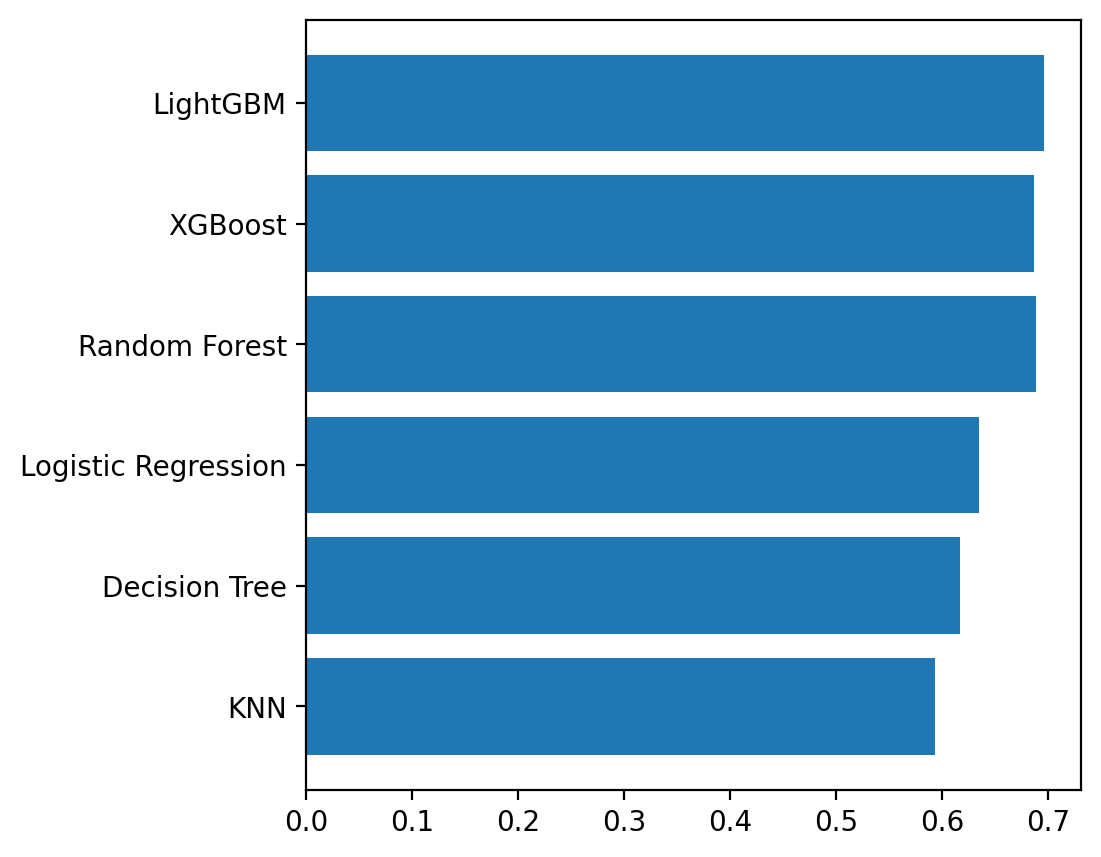

In [27]:
# 성능 시각화 비교
plt.figure(figsize=(5, 5))
plt.barh(list(result), result.values())
plt.show()

# 6.성능 튜닝

- 위에서 성능이 가장 좋을 것으로 예측된 알고리즘으로 모델링합니다.
- 본 실습에서는 하이퍼파라미터가 최적화된 LightGBM 모델을 만듭니다.

In [28]:
# 파라미터 
param = {'max_depth': range(1, 21),
         'n_estimators': range(60, 131, 10)}

# 모델 선언
model = GridSearchCV(LGBMClassifier(verbose=-1),
                     param,
                     cv=5,
                     scoring='accuracy')

In [29]:
# 학습하기(많은 시간이 소요될 수 있음)
model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(verbose=-1),
             param_grid={'max_depth': range(1, 21),
                         'n_estimators': range(60, 131, 10)},
             scoring='accuracy')

In [30]:
# 최적 파라미터, 예측 최고 성능
print(model.best_params_)
print(model.best_score_)

{'max_depth': 4, 'n_estimators': 60}
0.6994999999999999


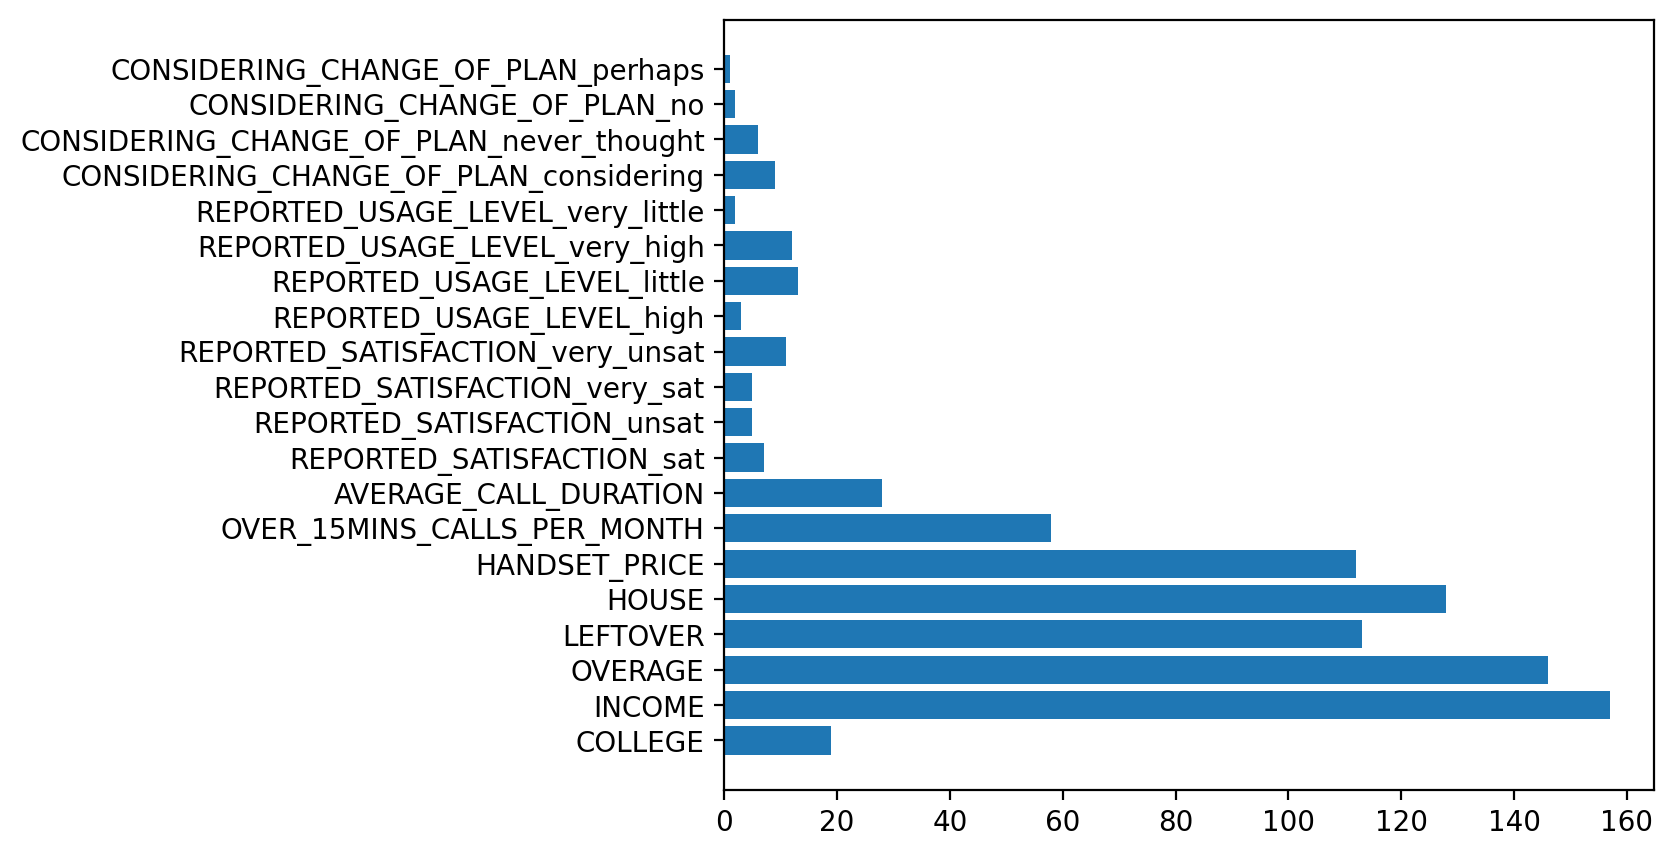

In [31]:
# 변수 중요도 시각화
plt.figure(figsize=(6, 5))
plt.barh(list(x), model.best_estimator_.feature_importances_)
plt.show()

# 7.성능 평가

- 최적 파라미터로 학습된 모델에 대해 최종 성능 평가를 진행합니다.

In [32]:
# 예측하기
y_pred = model.predict(x_test)

In [33]:
# 성능평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1928 1137]
 [ 673 2262]]
              precision    recall  f1-score   support

           0       0.74      0.63      0.68      3065
           1       0.67      0.77      0.71      2935

    accuracy                           0.70      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.70      0.70      0.70      6000

